# MorphCT

goal: 
 - atomistic gsd snapshot -> 
 - assign chromophores -> 
 - do QCC calcs -> 
 - run KMC -> 
 - calculate mobility

current schema:
 - xml file
 - chromphore params set in par.py
 - if starting with atomistic, we can skip fine graining and molecular dynamics and only run:
     - execute_obtain_chromophores = False                                             
     - execute_ZINDO = False                                                           
     - execute_calculate_transfer_integrals = False                                    
     - execute_calculate_mobility = False    

In [1]:
from collections import defaultdict
import itertools
import os
import pickle
import multiprocessing as mp

import ele
import freud
import gsd.hoomd
import mbuild as mb
import numpy as np
from openbabel import openbabel
from openbabel import pybel
import pyscf
from pyscf.semiempirical import MINDO3

from morphct.code import obtain_chromophores as oc
from morphct import transfer_integrals as ti
from morphct import execute_qcc as eqcc
from morphct import mobility_kmc as kmc
from morphct import chromophores
from morphct.utils import kmc_analyze
from morphct.chromophores import conversion_dict

/Users/jenny/miniconda3/envs/morphct-dev/lib/python3.7/site-packages/pyscf/lib/misc.py:50: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
def visualize_qcc_input(qcc_input):
    comp = mb.Compound()
    for line in qcc_input.split(";")[:-1]:
        atom, x, y, z = line.split()
        xyz = np.array([x,y,z], dtype=float)
        # Angstrom -> nm
        xyz /= 10
        comp.add(mb.Particle(name=atom,pos=xyz))
    comp.visualize().show()
    
def from_snapshot(snapshot, scale=1.0):
    """Convert a hoomd.data.Snapshot or a gsd.hoomd.Snapshot to an
    mbuild Compound.
    Parameters
    ----------
    snapshot : hoomd.data.SnapshotParticleData or gsd.hoomd.Snapshot
        Snapshot from which to build the mbuild Compound.
    scale : float, optional, default 1.0
        Value by which to scale the length values
    Returns
    -------
    comp : mb.Compound
    """
    comp = mb.Compound()
    bond_array = snapshot.bonds.group
    n_atoms = snapshot.particles.N

    # There will be a better way to do this once box overhaul merged
    try:
        # gsd
        box = snapshot.configuration.box
        comp.box = mb.box.Box(lengths=box[:3] * scale)
    except AttributeError:
        # hoomd
        box = snapshot.box
        comp.box = mb.box.Box(lengths=np.array([box.Lx,box.Ly,box.Lz]) * scale)

    # to_hoomdsnapshot shifts the coords, this will keep consistent
    shift = np.array(comp.box.lengths)/2
    # Add particles
    for i in range(n_atoms):
        name = snapshot.particles.types[snapshot.particles.typeid[i]]
        xyz = snapshot.particles.position[i] * scale + shift
        charge = snapshot.particles.charge[i]

        atom = mb.Particle(name=name, pos=xyz, charge=charge)
        comp.add(atom, label=str(i))

    # Add bonds
    particle_dict = {idx: p for idx, p in enumerate(comp.particles())}
    for i in range(bond_array.shape[0]):
        atom1 = int(bond_array[i][0])
        atom2 = int(bond_array[i][1])
        comp.add_bond([particle_dict[atom1], particle_dict[atom2]])
    return comp

OK, so I'm looking around for an xml file in the "obtain chromophores" tests but all I can find are these pickle files. I want to view them before I continue. ovito and vmd no longer support xmls... gah --> using mbuild.

In [3]:
path = "tests/old_assets/donor_polymer/OC/donor_polymer_post_obtain_chromophores.pickle"
(
    AA_morphdict, 
    CG_morphdict, 
    CGtoAAID_list, 
    param_dict, 
    chromo_list_old
) = pickle.load(open(path,"rb"))

In [4]:
with gsd.hoomd.open(name='tests/assets/p3ht_2_15mers.gsd', mode='rb') as f:
    snap = f[0]

In [5]:
box = snap.configuration.box[:3]
unwrapped_positions = snap.particles.position + snap.particles.image * box

In [6]:
##Run this if you want to confirm that the unwrapped positions are correct in OVITO
#with gsd.hoomd.open(name='test.gsd', mode='wb') as f:
#    f.append(snap)
#    snap.particles.position = unwrapped_positions
#    f.append(snap)

In [7]:
smarts_str = "[#6]1[#6][#16][#6][#6]1CCCCCC"

In [8]:
aaids = chromophores.get_chromo_ids_smiles(snap, smarts_str, conversion_dict)

Found 29 chromophores.


Basically, the smarts matching misses one chromophore. So I have to add it. There are some commented out cells below that show how I determine the atom indices and visualized it.

In [9]:
bad_inds = np.array([727,728,729,730,731,732,733,734,735,736,737])
aaids.append(bad_inds)
print(len(aaids))

30


In [10]:
#[row for row in snap.bonds.group if set(row) & set(bad_inds)]

#comp = from_snapshot(snap, scale=0.1)
#for i,p in enumerate(comp.particles()):
#    if i in np.hstack(aaids):
#        p.name = "Kr"
#    elif i in bad_inds:
#        p.name = "N"
#    else:
#        p.name = p.name.strip("0123456789")
#comp.visualize().show()

In [11]:
#molpos_init = np.array([
#    (mol.GetAtomById(i).GetX(), mol.GetAtomById(i).GetY(), mol.GetAtomById(i).GetZ()) 
#    for i in range(mol.NumAtoms())
#])

#uff = openbabel.OBForceField.FindForceField("UFF")
#uff.Setup(mol)
#uff.SteepestDescent(100)
#uff.UpdateCoordinates(mol)

#molpos_final = np.array([
#    (mol.GetAtomById(i).GetX(), mol.GetAtomById(i).GetY(), mol.GetAtomById(i).GetZ()) 
#    for i in range(mol.NumAtoms())
#])

#for i, (row, newrow) in enumerate(zip(molpos_init,molpos_final)):
#    if not np.array_equal(row, newrow):
#        print(i, row, newrow)

In [12]:
chromo_list = []
for i,aaid in enumerate(aaids):
    chromo_list.append(chromophores.Chromophore(i, snap, aaid, "donor", conversion_dict))

In [13]:
#with open("chromo_list.pkl", "wb") as f:
#    pickle.dump(chromo_list, f)

In [14]:
#with open("chromo_list.pkl", "rb") as f:
#    chromo_list = pickle.load(f)

Next let's get the neighbors

In [15]:
qcc_pairs = chromophores.set_neighbors_voronoi(
    chromo_list, snap, conversion_dict, d_cut=min(box)/2
)
print(len(qcc_pairs))

181


In [16]:
#with open("qcc_pairs.pkl", "wb") as f:
#    pickle.dump(qcc_pairs, f)

In [17]:
#with open("chromo_list_neighbors.pkl", "wb") as f:
#    pickle.dump(chromo_list, f)

In [18]:
# Checked and all pairs look reasonable!
#i = 13
#visualize_qcc_input(qcc_pairs[i][1])

next need to run ZINDO

`eqcc.get_homolumo(chromo_list[0].qcc_input)` returns HOMO-1, HOMO, LUMO, LUMO+1

`eqcc.singles_homolumo` does for all chromophores

In [19]:
outpath = os.path.join(os.getcwd(), "notebook_output")
s_filename = os.path.join(outpath, "singles_energies.txt")
print(s_filename)

/Users/jenny/Projects/morphct/notebook_output/singles_energies.txt


In [20]:
#%%time
#data = eqcc.singles_homolumo(chromo_list, s_filename)
#
#CPU times: user 20.9 ms, sys: 30.1 ms, total: 51 ms
#Wall time: 6.05 s

This gets the energy values of the chromophores using the single inputs and writes them to a file. No energy values are set:

In [21]:
chromo = chromo_list[0]
print(chromo.homo)
print(len(chromo.neighbors), len(chromo.neighbors_delta_e))
print(chromo.neighbors_delta_e[0])

None
14 14
None


Next compute the pair energies:

In [22]:
d_filename = os.path.join(outpath, "dimer_energies.txt")
print(d_filename)

/Users/jenny/Projects/morphct/notebook_output/dimer_energies.txt


In [23]:
#%%time
#dimer_data = eqcc.dimer_homolumo(qcc_pairs, d_filename)
#
#CPU times: user 20.3 ms, sys: 27.2 ms, total: 47.6 ms
#Wall time: 56.6 s

In [24]:
data = eqcc.get_singlesdata(s_filename)
print(data[0])
dimer_data = eqcc.get_dimerdata(d_filename)
print(dimer_data[0])

[-9.01337182 -8.5404688   0.17193304  0.86523495]
((0, 1), (-8.709172080560474, -8.217563821747863, -0.26434041537131636, 0.35184321402975144))


In [25]:
eqcc.set_energyvalues(chromo_list, s_filename, d_filename)

In [26]:
with open("chromo_list_energies.pkl", "wb") as f:
    pickle.dump(chromo_list, f)

In [27]:
print(chromo.homo)
print(len(chromo.neighbors), len(chromo.neighbors_delta_e))
print(chromo.neighbors_delta_e[0])

-8.54046879758057
14 14
-0.016112646653095197


OK, I think I should be ready to run KMC. Before it'll work we need to add some things to the param dict and change some paths.

```
notebook_outputs/KMC/ 
```

run_kmc : single_core_run_mob_KMC

kmc : mobility_KMC

In [28]:
seed = param_dict['random_seed_override']

In [29]:
jobs_list = kmc.get_jobslist([1.00e-13, 1.00e-12], n_holes=10, seed=seed)

In [30]:
kmc_directory = os.path.join(outpath, "KMC")

Multiprocessing gives a reasonable speedup! (see below)

In [31]:
#%%time
#
#box = snap.configuration.box[:3]
#temp = 300
#
#running_jobs = []
#pipes = []
#
#for jobs in jobs_list:
#    child_seed = np.random.randint(0, 2 ** 32)                              
#                                                                            
#    recv_end, send_end = mp.Pipe(False)                                     
#    p = mp.Process(                                                         
#            target=kmc.run_single_kmc,                                          
#            args=(                                                          
#                jobs,                                                       
#                KMC_directory,                                              
#                chromo_list,                                                
#                box,                                                        
#                temp,                                                     
#                ),                                                          
#            kwargs={                                                                                                                       
#                "seed": child_seed,                                         
#                "send_end": send_end,                                                                             
#                }                                                           
#            )                                                               
#    running_jobs.append(p) 
#    pipes.append(recv_end)                                                  
#    p.start()
#    
#for p in running_jobs:                                                      
#    p.join()                                                                
#
#carrier_data_list = [x.recv() for x in pipes]  
#
#CPU times: user 13.3 ms, sys: 20.9 ms, total: 34.1 ms
#Wall time: 1.67 s

#%%time
#
#box = snap.configuration.box[:3]
#temp = 300
#
#carrier_data_list = []
#
#for jobs in jobs_list: 
#    child_seed = np.random.randint(0, 2 ** 32) 
#    data = kmc.run_single_kmc(
#        jobs,                                                       
#        KMC_directory,                                              
#        chromo_list,                                                
#        box,                                                        
#        temp,                                                                                                                                                                        
#        seed= child_seed
#    )                                                             
#
#    carrier_data_list.append(data)

#CPU times: user 3.67 s, sys: 535 ms, total: 4.21 s
#Wall time: 4.02 s

In [32]:
temp = 300
combined_data = kmc.run_kmc(
    jobs_list, kmc_directory, chromo_list, snap, temp, verbose=1
)

All KMC jobs completed!
Combining outputs...


---------- KMC_ANALYZE ----------
All figures saved in /Users/jenny/Projects/morphct/notebook_output/KMC/figures
---------------------------------
Considering the transport of hole...
Obtaining mean squared displacements...
	Notice: The data from 2 carriers were
	discarded due to the carrier lifetime being more than double
	(or less than half of) the specified carrier lifetime.
Plotting distribution of hole displacements
	Figure saved as hole_displacement_dist.png
Calculating mobility...
Standard Error 0.0
Fitting r_val = 1.0
	Figure saved as lin_MSD_hole.png
	Figure saved as semi_log_MSD_hole.png
	Figure saved as log_MSD_hole.png
----------------------------------------
Hole mobility = 3.28E-01  +/- 2.03E-02 cm^2 V^-1 s^-1
----------------------------------------
Calculating hole trajectory anisotropy...
----------------------------------------
hole charge transport anisotropy: 0.235
----------------------------------------
Plotting hole hop frequency distribution...
DYNAMIC CUT
Notic

NameError: name 'cutoff' is not defined

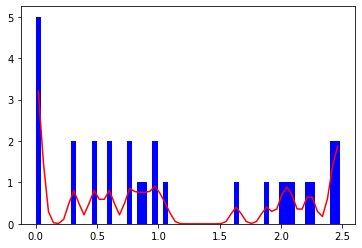

In [33]:
kmc_analyze.main(combined_data, temp, chromo_list, snap, kmc_directory)

In [ ]:
#start = 1359
#stop = 1412
#with open("./morphct/utils/kmc_analyze.py", "r") as f:
#    lines = f.readlines()
#print(*lines[start-1:stop])